# Modelo ResNet-50

En este notebook vamos a implementar el modelo de red neuronal convolucional ResNet-50. Explicaremos a grandes rasgos las distintas partes de la arquitectura. Los detalles pueden ser consultados en el artículo: https://arxiv.org/abs/2201.03545


### Preparación de los datos

Entrenaremos al modelo en el conjunto de datos CIFAR-10. Este dataset consiste de 60000 imágenes a color en 10 clases distintas, donde no hay intersección entre las distintas clases. Se puede acceder al dataset mediante las herramientas de la paquetería de pytorch, o también en la página oficial: https://www.cs.toronto.edu/~kriz/cifar.html

In [16]:
# Importamos las paqueterías necesarias para el notebook
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# De ser posible utilizaremos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
    """
    Función para cargar los datos de CIFAR-10
    """
    
    # Definimos el transform para normalizar los datos con pytorch
    # Los valores fueron obtenidos en el notebook de datos "data_extraction.ipynb"
    normalize = transforms.Normalize(  
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Definimos el transform para preporcesar los datos
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Tomo imágenes de 34x34 para evitar una excepción en pytorch al normalizar la última capa
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    # Obtener los datos del conjunto de prueba
    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # Cargamos una copia de los datos de entrenamiento
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Cargamos una copia extra de los datos de entrenamiento para dividirlo después en el conjunto de validación
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Separamos los datos de entrenamiento y validación mediante índices
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Finalmente, definimos los conjuntos de entrenamiento y validación
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Aplicamos la función para cargar los datos de CIFAR-10, los guardamos en el directorio actual
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)    
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definición del modelo

Explicar el modelo, como lo vamos a construir, como lo vamos a testear. Mencionar que nos vamos a basar en el articulo de ResNet

### Batch normalization

Para evitar el problema *vanishing/exploding gradients*, los autores del artículo emplean *batch normalization*. Para simplificar el uso de este tipo de capa, creamos una capa de utilidad __utilConv__ que aplica una convolución, normalización y la función de activación. La siguiente imagen ejemplifica dicha capa:

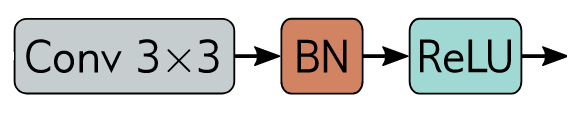

In [18]:
class utilConv(nn.Sequential):
    """
    Bloque de utilidad compuesta por una capa de convolución seguida de una de normalización y luego una de activación.
    """
    def __init__(self, in_features, out_features, kernel_size, stride = 1, norm = nn.BatchNorm2d, act = nn.ReLU, bias=True):
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size ,padding=kernel_size // 2, stride=stride, bias=bias),
            norm(out_features),
            act()
        )

### Bottleneck

El bloque residual utilizado en ResNet-50 es conocido como *bottleneck*. Su principal utilidad es el de aumentar el de aumentar la eficiencia de la red neuronal mediante la disminución temporal del número de canales de los datos. La siguiente imagen, tomada del artículo, ejemplifica su funcionamiento:

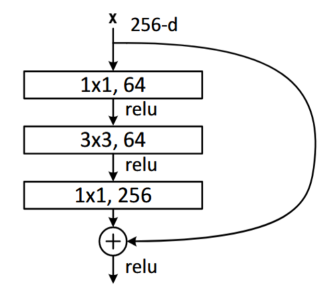

In [19]:
class BottleNeckBlock(nn.Module):
    def __init__(self,in_features, out_features, reduction = 4, stride = 1):
        super().__init__()
        reduced_features = out_features // reduction
        self.block = nn.Sequential(
            # Reducción de canales
            utilConv(in_features, reduced_features, kernel_size=1, stride=stride, bias=False), # el stride puede ser 2 para aplicar downsampling
            # El número de canales se mantiene fijo
            utilConv(reduced_features, reduced_features, kernel_size=3, bias=False),
            # Aumento de canales
            utilConv(reduced_features, out_features, kernel_size=1, bias=False, act=nn.Identity), 
        )
        
        # self.shortcut es utilizado para transformar al input a las dimensiones correctas para poder sumarlo a la salida del bloque
        if in_features != out_features:
            self.shortcut =nn.Sequential(utilConv(in_features, out_features, kernel_size=1, stride=stride, bias=False))
        else:
            self.shortcut = nn.Identity()

        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.block(x)
        res = self.shortcut(res)
        x += res
        x = self.act(x)
        return x

### Stage

La arquitectura ResNet-50 cuenta con 4 conjuntos de bloques _bottlencek_, cada uno de estos conjuntos es llamado *stage*. En la siguiente imagen están encerrados en rojo los 4 _stages_ de la arquitectura ResNet-50

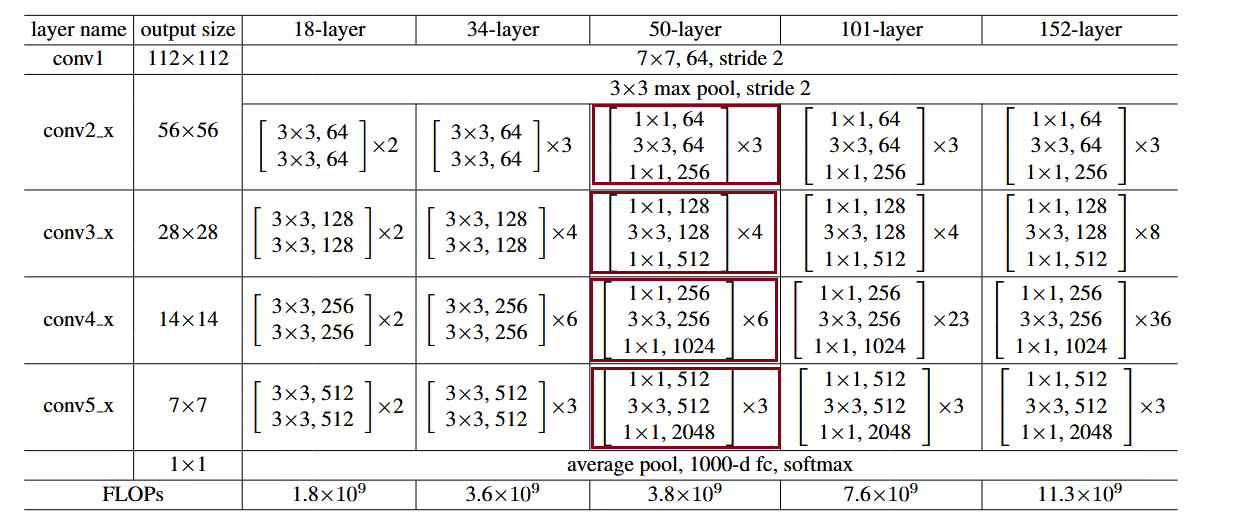

In [20]:
class Stage(nn.Sequential):
    """
    Esta capa define al "stage", el cual es un conjunto de bloques residuales
    depth es el número de bloques residuales
    in_features el numero de canales con que empieza
    out_features el numer de canales con que termina
    """
    def __init__(self, in_features, out_features, depth, stride = 2):  # in_features y out_features deben ser distintos, sino se aplicará downsampling y el Bottleneck no aplicará la identidad
        super().__init__(
            
            BottleNeckBlock(in_features, out_features, stride=stride), # Aquí se lleva a cabo el downsampling
            *[BottleNeckBlock(out_features, out_features) for _ in range(depth - 1)]
        )

### Estructura "stem cell"

El primer procesamiento al input en el modelo resnet es conocido por el nombre "stem cell", éste consiste en una capa convolucional seguida de una capa de MaxPool. Sin embargo, en el artículo de ResNet deciden no aplicar _downsampling_ al conjunto de datos CIFAR-10, por lo que utilizaremos en la primera convolución un kernel de dimensión 3 y no utilizaremos MaxPool.

In [21]:
class Stem(nn.Sequential):
    def __init__(self, in_features, out_features):
        super().__init__(
            utilConv(in_features, out_features, kernel_size=3, stride=1),  # en el caso de ImageNet, el kernel es de tamaño 7
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  
        )

### Encoder

El Encoder de la arquitectura ResNet abarca todos los elementos mencionados hasta este punto. Es en el Encoder donde se procesan los datos con la intención de extraer sus características principales para después ser clasificados por el Decoder. 

In [22]:
class Encoder(nn.Module):
    
    """
    widths es una lista con el número de canales respectivos al final de cada "stage"
    depths es una lista con el numero de bloques residuales que tendrá cada "stage"
    stem_features es el número de canales que resulta de la primera capa de downsampling
    
    """
    def __init__(self, in_channels, stem_features, depths, widths):  # 
        super().__init__()
        self.stem = Stem(in_channels, stem_features)

        in_out_widths = list(zip(widths, widths[1:]))

        
        self.stages = nn.ModuleList() # lista de pytorch con los stages
        
        self.stages.append(Stage(stem_features, widths[0], depths[0], stride=1)) # se puede inferir de la figura 1 del artículo que el primer bloque del stage1 tiene stride 1
        
        for (in_features, out_features), depth in zip(in_out_widths, depths[1:]):
            # añadir cada uno de los stages
            self.stages.append(Stage(in_features, out_features, depth))
            

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:

            x = stage(x)
        return x

### Decoder

En ResNet, el Decoder es la parte de la red neuronal encargada de ajustar las dimensiones de los datos procesados por el Encoder para poder clasificarlos. ultimo del resnet fig3 avg pool y fc

In [23]:
class Decoder(nn.Module):
    """
    Capa para clasificar los datos
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        x = F.softmax(x, dim=1)
        return x

In [24]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, stem_features, depths, widths ):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, stem_features=stem_features, depths=depths, widths=widths)
        self.decoder = Decoder(widths[-1], n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Ejemplo de creación y uso del modelo ResNet-50

In [25]:
resnet50 = ResNet(in_channels=3, n_classes = 10, stem_features=64, depths=[3,4,6,3], widths=[64, 128, 256,512]).to(device)
resnet50(torch.rand(1,3,32,32).to(device)).shape

torch.Size([1, 10])

In [26]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

### Entrenamiento

In [27]:
import gc
def entrenamiento():
    # variables para guardar los resultados
    accuracy_training_epochs = []
    accuracy_validation_epochs = []
    loss_epoch = []
    test_accuracy = []
    
    # hiperparámetros
    num_epochs = 90

    model = ResNet(in_channels=3, n_classes = 10, stem_features=64, depths=[3,4,6,3], widths=[64, 128, 256, 512]).to(device)

    optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=60, gamma=0.1)

    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    # entrenamiento
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, (images, labels) in enumerate(train_loader):

            # Mover a los tensores a GPU de ser posible
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass y descenso de gradiente estocástico
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ahorro de memoria
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        loss_epoch.append(loss.item())
        lr_scheduler.step() # Implementación de learning rate decay

        # Exactitud en el conjunto de validación
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            val_accuracy = correct/total
            accuracy_validation_epochs.append(val_accuracy)

        # Exactitud en el total del conjunto de entrenamiento
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            train_accuracy = correct/total
            accuracy_training_epochs.append(train_accuracy)

        # Exactitud en el conjunto de prueba
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            t_acc = correct/total
            test_accuracy.append(t_acc)



        print(f"Epoch [{epoch+1}/{num_epochs}], Training accuracy: {round(train_accuracy,3)}, Validation accuracy: {round(val_accuracy,3)}, loss = {round(loss_epoch[-1],3)}")
        print(f"Time spent on epoch {epoch+1}: {round((time.time()-start_time)/60,2)}min")
        
    return [model,
            accuracy_training_epochs,
            accuracy_validation_epochs,
            test_accuracy,
            loss_epoch]  # model, training accuracy, validation accuracy, test accuracy, loss
    
    
    
    

In [28]:
# repetimos 3 veces el experimento
model1, training1, validation1, test1, loss1 = entrenamiento()
model2, training2, validation2, test2, loss2 = entrenamiento()
model3, training3, validation3, test3, loss3 = entrenamiento()

Epoch [1/90], Training accuracy: 0.261, Validation accuracy: 0.253, loss = 2.179
Time spent on epoch 1: 3.28min
Epoch [2/90], Training accuracy: 0.251, Validation accuracy: 0.248, loss = 1.99
Time spent on epoch 2: 3.19min
Epoch [3/90], Training accuracy: 0.291, Validation accuracy: 0.287, loss = 2.321
Time spent on epoch 3: 3.08min
Epoch [4/90], Training accuracy: 0.318, Validation accuracy: 0.309, loss = 2.237
Time spent on epoch 4: 3.15min
Epoch [5/90], Training accuracy: 0.318, Validation accuracy: 0.324, loss = 2.251
Time spent on epoch 5: 3.12min
Epoch [6/90], Training accuracy: 0.352, Validation accuracy: 0.349, loss = 2.232
Time spent on epoch 6: 3.34min
Epoch [7/90], Training accuracy: 0.367, Validation accuracy: 0.358, loss = 1.935
Time spent on epoch 7: 3.2min
Epoch [8/90], Training accuracy: 0.385, Validation accuracy: 0.379, loss = 2.087
Time spent on epoch 8: 3.11min
Epoch [9/90], Training accuracy: 0.42, Validation accuracy: 0.412, loss = 1.898
Time spent on epoch 9: 3.2

Epoch [74/90], Training accuracy: 0.869, Validation accuracy: 0.844, loss = 1.775
Time spent on epoch 74: 3.3min
Epoch [75/90], Training accuracy: 0.875, Validation accuracy: 0.846, loss = 1.714
Time spent on epoch 75: 3.29min
Epoch [76/90], Training accuracy: 0.872, Validation accuracy: 0.845, loss = 1.712
Time spent on epoch 76: 3.47min
Epoch [77/90], Training accuracy: 0.876, Validation accuracy: 0.851, loss = 1.593
Time spent on epoch 77: 3.29min
Epoch [78/90], Training accuracy: 0.876, Validation accuracy: 0.846, loss = 1.814
Time spent on epoch 78: 3.43min
Epoch [79/90], Training accuracy: 0.878, Validation accuracy: 0.854, loss = 1.584
Time spent on epoch 79: 3.45min
Epoch [80/90], Training accuracy: 0.881, Validation accuracy: 0.849, loss = 1.564
Time spent on epoch 80: 3.29min
Epoch [81/90], Training accuracy: 0.882, Validation accuracy: 0.852, loss = 1.464
Time spent on epoch 81: 3.29min
Epoch [82/90], Training accuracy: 0.885, Validation accuracy: 0.851, loss = 1.867
Time sp

Epoch [57/90], Training accuracy: 0.775, Validation accuracy: 0.766, loss = 1.742
Time spent on epoch 57: 3.05min
Epoch [58/90], Training accuracy: 0.764, Validation accuracy: 0.744, loss = 1.596
Time spent on epoch 58: 3.04min
Epoch [59/90], Training accuracy: 0.781, Validation accuracy: 0.77, loss = 1.949
Time spent on epoch 59: 3.06min
Epoch [60/90], Training accuracy: 0.773, Validation accuracy: 0.764, loss = 1.498
Time spent on epoch 60: 3.04min
Epoch [61/90], Training accuracy: 0.83, Validation accuracy: 0.813, loss = 1.685
Time spent on epoch 61: 3.04min
Epoch [62/90], Training accuracy: 0.837, Validation accuracy: 0.815, loss = 1.586
Time spent on epoch 62: 3.05min
Epoch [63/90], Training accuracy: 0.841, Validation accuracy: 0.822, loss = 1.498
Time spent on epoch 63: 3.13min
Epoch [64/90], Training accuracy: 0.848, Validation accuracy: 0.825, loss = 1.589
Time spent on epoch 64: 3.05min
Epoch [65/90], Training accuracy: 0.852, Validation accuracy: 0.829, loss = 1.845
Time spe

Epoch [40/90], Training accuracy: 0.721, Validation accuracy: 0.708, loss = 1.832
Time spent on epoch 40: 3.51min
Epoch [41/90], Training accuracy: 0.728, Validation accuracy: 0.72, loss = 1.825
Time spent on epoch 41: 4.33min
Epoch [42/90], Training accuracy: 0.73, Validation accuracy: 0.715, loss = 1.701
Time spent on epoch 42: 4.51min
Epoch [43/90], Training accuracy: 0.737, Validation accuracy: 0.727, loss = 1.614
Time spent on epoch 43: 4.54min
Epoch [44/90], Training accuracy: 0.741, Validation accuracy: 0.726, loss = 1.465
Time spent on epoch 44: 3.8min
Epoch [45/90], Training accuracy: 0.737, Validation accuracy: 0.718, loss = 1.693
Time spent on epoch 45: 3.08min
Epoch [46/90], Training accuracy: 0.733, Validation accuracy: 0.722, loss = 1.913
Time spent on epoch 46: 3.07min
Epoch [47/90], Training accuracy: 0.748, Validation accuracy: 0.731, loss = 1.87
Time spent on epoch 47: 3.07min
Epoch [48/90], Training accuracy: 0.729, Validation accuracy: 0.713, loss = 2.07
Time spent 

In [80]:
# guardar uno de los modelos
torch.save(model1,"./model_ResNet-50.pt")

### Resultados

In [41]:
import pandas as pd

In [30]:
# Guardar en csv
results_dict1 = {"loss": loss1,
    'Train':training1,
     'Validation': validation1,
     "Test":test1}
results_dict2 = {"loss": loss2,
    'Train':training2,
     'Validation': validation2,
     "Test":test2}
results_dict3 = {"loss": loss3,
    'Train':training3,
     'Validation': validation3,
     "Test":test3}

pd.DataFrame(results_dict1).to_csv("./results/results_ResNet50_1.csv",index=False)
pd.DataFrame(results_dict2).to_csv("./results/results_ResNet50_2.csv",index=False)
pd.DataFrame(results_dict3).to_csv("./results/results_ResNet50_3.csv",index=False)

In [31]:
results1 = pd.DataFrame(results_dict1)
results2 = pd.DataFrame(results_dict2)
results3 = pd.DataFrame(results_dict3)

In [39]:
# Accuracy 
accuracy = (results1["Test"].max() + results2["Test"].max() + results3["Test"].max())/3
print(accuracy)

0.8250000000000001


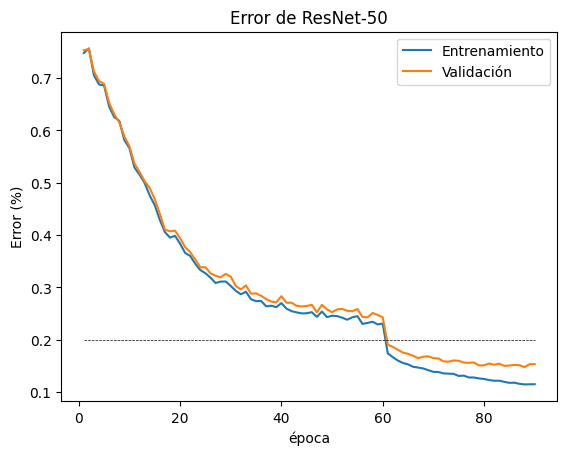

In [75]:
# graficar resultados
import matplotlib.pyplot as plt

x_axis = np.arange(90)+1
validation_err = 1- (np.array(validation1) + np.array(validation2) + np.array(validation3) )/3
train_err = 1- (np.array(training1)+np.array(training2)+np.array(training3))/3

plt.plot(x_axis, train_err)
plt.plot(x_axis, validation_err)
plt.plot(x_axis, np.ones(90)*0.2, 'k--', linewidth = 0.5)
plt.title("Error de ResNet-50")
plt.ylabel('Error (%)')
plt.xlabel('época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()
plt.close()

### Ejemplo de predicción

Decir qué vamos a ponerlo a prueba al modelo

In [ ]:
# cargar modelo


In [ ]:
# poner 10 imágenes y de título su predicción.
